### **Aprendizado de Máquina 1**
#### Trabalho 2: Aprendizado Não-supervisionado - Espécies de Flores

Prof. Dr. Diego Furtado

  **Alunos:**

    Caio Ueno
    Claudia Sanches
    Gabriel Cheban
    Igor Torga
    Vinicius Carvalho

### **Descrição do Projeto:** 

Este projeto é sobre o estudo de algoritmos de aprendizado de máquina não-supervisionado sobre um *dataset* de imagens de flores. Os algoritmos adotados para o estudo são: *Optics*, *Agglomerative Clustering* e *K-means*. O *dataset* conta com 603 imagens distintas, com um total de 19 espécies diferentes.
  ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd


from sklearn.cluster import OPTICS, KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import os

---
Carregamento do *dataset*, assim como a extração do rótulo "verdadeiro" - espécies.



In [ ]:
# dataset that contains images' path and label
data = pd.DataFrame()
data['image-name'] = os.listdir('drive/MyDrive/colab-data/flowers/')

# extracting species
data['species'] = data['image-name'].apply(lambda x: int(x[:2]))

# saving "true" label
np.save('drive/MyDrive/colab-data/true_label.npy', data['species'].values)

FileNotFoundError: ignored

---
Salvamento das imagens "cruas".

In [ ]:
raw_images_flatten = np.array([plt.imread('drive/MyDrive/colab-data/flowers/'+img).ravel() for img in data['image-name'].tolist()])
# saving raw images
np.save('drive/MyDrive/colab-data/raw_images_flatten.npy', raw_images_flatten)

---
Redução da dimensão das imagens para 600 utilizando PCA e salvando-as.

In [ ]:
def reduce_dim(imgs, k):
    pca = PCA(n_components=k)
    return pca.fit_transform(imgs)

images_600 = reduce_dim(raw_images_flatten, 600)
# saving reduced images
np.save('drive/MyDrive/colab-data/images_600.npy', images_600)

---
Instanciação de um modelo de rede neural siamesa. Sendo uma tentativa de melhorar a clusterização, redefinindo o espaço.

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
import tensorflow as tf

# embeddings size
EMBED_SIZE = 128

input_image = Input(shape=(128, 128, 4))
x = Conv2D(32, (3, 3), activation='relu')(input_image)
x = MaxPool2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = Flatten()(x)
x = Dense(EMBED_SIZE, activation='relu')(x)

base_network = Model(inputs=input_image, outputs=x)

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :EMBED_SIZE], y_pred[:, EMBED_SIZE:2*EMBED_SIZE], y_pred[:, 2*EMBED_SIZE:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + 0.2, 0.)

input_image_one = Input(shape=(128, 128, 4), name='input_image_one') # input layer for image one
input_image_two = Input(shape=(128, 128, 4), name='input_image_two') # input layer for image two
input_image_three = Input(shape=(128, 128, 4), name='input_image_three') # input layer for image three

out = concatenate([base_network(input_image_one), base_network(input_image_two),
                             base_network(input_image_three)])

model = Model(inputs=[input_image_one, input_image_two, input_image_three],
            outputs=out)
model.compile(loss=triplet_loss, optimizer='rmsprop')

---
Definição do gerador para treinamento da rede neural.

In [ ]:
def image_batch_generator(images_names_df, embed_size, batchsize=32):
    
    while True:
        
        images_names = images_names_df.sample(batchsize)['image-name'].tolist()
        anchors, positives, negatives, masks = [], [], [], []
        
        for img_name in images_names:
            
            anchor = plt.imread('drive/MyDrive/colab-data/flowers/'+img_name)
            anchor_class = int(img_name[:2])
            
            positive_example = images_names_df[images_names_df['species'] == anchor_class].sample(1).iloc[0]['image-name']
            negative_example = images_names_df[images_names_df['species'] != anchor_class].sample(1).iloc[0]['image-name']
            
            anchors.append(anchor)
            positives.append(plt.imread('drive/MyDrive/colab-data/flowers/'+positive_example))
            negatives.append(plt.imread('drive/MyDrive/colab-data/flowers/'+negative_example))
            masks.append(np.zeros(3 * embed_size))
            
        yield [np.array(anchors), np.array(positives), np.array(negatives)], np.array(masks)  

---
Treinamento da rede neural siamesa com todos os dados.

In [ ]:
train_gen = image_batch_generator(data, EMBED_SIZE)
model.fit(train_gen, epochs=15, steps_per_epoch=60)

Epoch 1/15
60/60 [==============================] - 23s 338ms/step - loss: 0.1429
Epoch 2/15
60/60 [==============================] - 21s 345ms/step - loss: 0.1018
Epoch 3/15
60/60 [==============================] - 21s 344ms/step - loss: 0.0910
Epoch 4/15
60/60 [==============================] - 20s 341ms/step - loss: 0.0740
Epoch 5/15
60/60 [==============================] - 20s 340ms/step - loss: 0.0678
Epoch 6/15
60/60 [==============================] - 21s 345ms/step - loss: 0.0583
Epoch 7/15
60/60 [==============================] - 21s 343ms/step - loss: 0.0529
Epoch 8/15
60/60 [==============================] - 20s 338ms/step - loss: 0.0514
Epoch 9/15
60/60 [==============================] - 21s 344ms/step - loss: 0.0388
Epoch 10/15
60/60 [==============================] - 21s 344ms/step - loss: 0.0423
Epoch 11/15
60/60 [==============================] - 21s 347ms/step - loss: 0.0294
Epoch 12/15
60/60 [==============================] - 20s 339ms/step - loss: 0.0311
Epoch 13/15
6

---
Geração das *embeddings* para o conjunto de dados e salvando-as em disco.

In [ ]:
raw_images = np.array([plt.imread('drive/MyDrive/colab-data/flowers/'+img) for img in data['image-name'].tolist()])
# creating embeddings for each image
embeddings = base_network.predict(raw_images)
# saving embeddings' images
np.save('drive/MyDrive/colab-data/full_data_embeddings.npy', embeddings)

---
Variação da mesma abordagem com a rede neural siamesa, porém com apenas 10% dos dados rotulados.

In [ ]:
model = Model(inputs=[input_image_one, input_image_two, input_image_three],
            outputs=out)
model.compile(loss=triplet_loss, optimizer='rmsprop')

---
Geração do conjunto de dados parcial e treinamento da rede neural.

In [ ]:
data_undersized = data.sample(60)
train_gen = image_batch_generator(data_undersized, EMBED_SIZE, batchsize=16)
model.fit_generator(train_gen, epochs=15, steps_per_epoch=10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
10/10 [==============================] - 3s 161ms/step - loss: 0.0217
Epoch 2/15
10/10 [==============================] - 2s 180ms/step - loss: 0.0121
Epoch 3/15
10/10 [==============================] - 2s 175ms/step - loss: 0.0058
Epoch 4/15
10/10 [==============================] - 2s 182ms/step - loss: 0.0018
Epoch 5/15
10/10 [==============================] - 2s 173ms/step - loss: 0.0017
Epoch 6/15
10/10 [==============================] - 2s 174ms/step - loss: 0.0025
Epoch 7/15
10/10 [==============================] - 2s 177ms/step - loss: 0.0144
Epoch 8/15
10/10 [==============================] - 2s 172ms/step - loss: 6.8446e-04
Epoch 9/15
10/10 [==============================] - 2s 177ms/step - loss: 0.0020
Epoch 10/15
10/10 [==============================] - 2s 173ms/step - loss: 0.0031
Epoch 11/15
10/10 [==============================] - 2s 175ms/step - loss: 0.0056
Epoch 12/15
10/10 [==============================] - 2s 171ms/step - loss: 0.0014
Epoch 13/15
10/10 [==

---
Geração das *embeddings* para o conjunto de dados e salvando-as em disco.

In [ ]:
raw_images = np.array([plt.imread('drive/MyDrive/colab-data/flowers/'+img) for img in data['image-name'].tolist()])
# creating embeddings for each image
embeddings = base_network.predict(raw_images)
# saving embeddings' images
np.save('drive/MyDrive/colab-data/partial_data_embeddings.npy', embeddings)

---
Função para criar um gráfico dado um conjunto de dados bidimensional e rótulos associados a cada instância.

In [ ]:
def plot_embedding(X, y, title=None):
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(12, 12))
    plt.grid()
    # list_colors = ['dimgray', 'lightcoral', 'darkred', 'orangered', 'sandybrown', 'saddlebrown', 
    #                'orange', 'gold', 'beige', 'olive', 'olivedrab', 'lawngreen', 'darkseagreen',
    #                'forestgreen', 'dodgerblue', 'violet', 'crimson', 'navy', 'fuchsia', 'lavender']
    list_colors = cm.rainbow(np.linspace(0, 1, len(np.unique(y))))
    
    colors = list(map(lambda x: list_colors[x], y))

    plt.scatter(X[:, 0], X[:, 1], color=colors)
    
    if title is not None:
        plt.title(title, fontsize=14)
    plt.show()

---
Função que realiza o *pipeline* de clusterização, dado um conjunto de instâncias, rótulos "verdadeiros" e um modelo de clusterização.

In [ ]:
def run_on_batch(X, y, cluster_model):

    predicted = cluster_model.fit_predict(X, y)
    print("Adjusted rand_score: {}".format(adjusted_rand_score(y, cluster_model.labels_)))
    print("Silhouette: {}".format(silhouette_score(X, cluster_model.labels_)))
    
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne, cluster_model.labels_, "t-SNE das classes")
    print()
    print('=====================================================================')

---
Carregamento dos dados das diversas variações.

In [ ]:
true_labels = np.load('drive/MyDrive/colab-data/true_label.npy')

raw_images = np.load('drive/MyDrive/colab-data/raw_images_flatten.npy')
images_600 = np.load('drive/MyDrive/colab-data/images_600.npy')
full_data_embeddings = np.load('drive/MyDrive/colab-data/full_data_embeddings.npy')
partial_data_embeddings = np.load('drive/MyDrive/colab-data/partial_data_embeddings.npy')

---

Distribuição imagens com o rótulo "verdadeiro" em cada modelagem proposta.

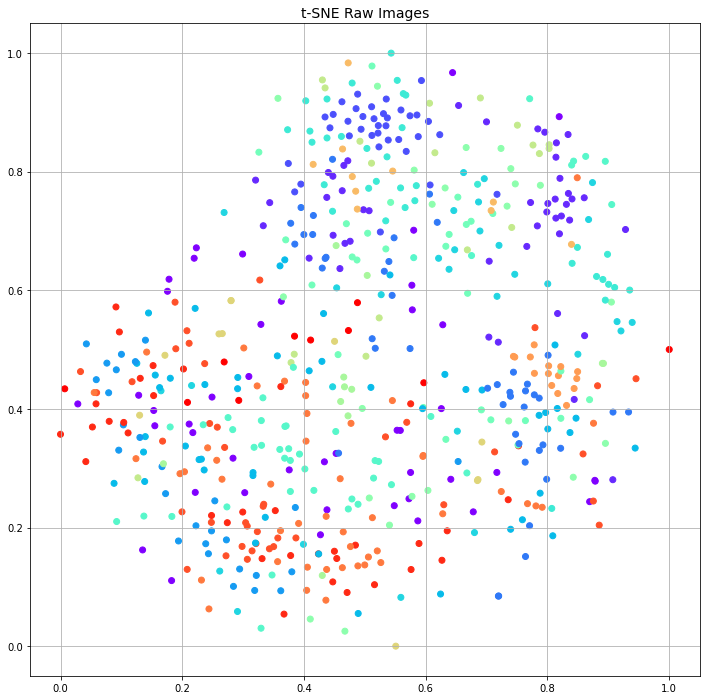

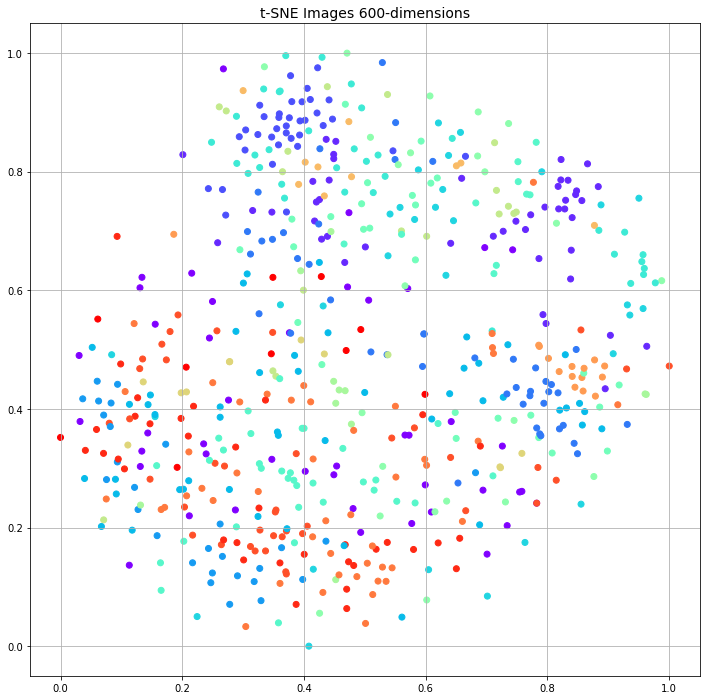

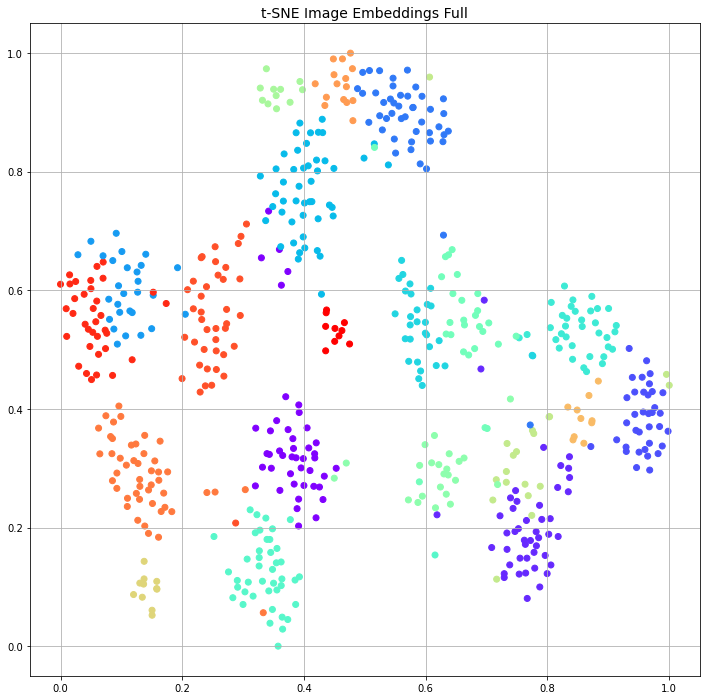

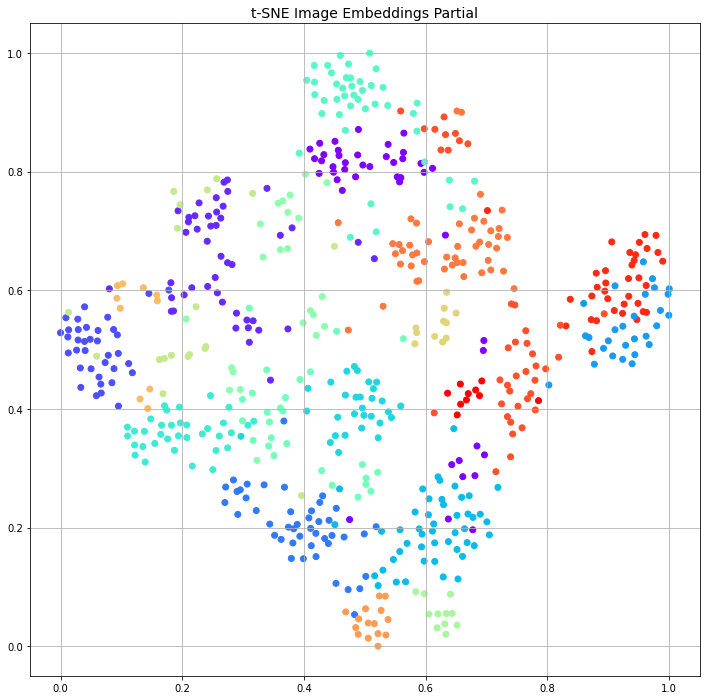

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(raw_images)
plot_embedding(X_tsne, true_labels, "t-SNE Raw Images")

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(images_600)
plot_embedding(X_tsne, true_labels, "t-SNE Images 600-dimensions")

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(full_data_embeddings)
plot_embedding(X_tsne, true_labels, "t-SNE Image Embeddings Full")

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(partial_data_embeddings)
plot_embedding(X_tsne, true_labels, "t-SNE Image Embeddings Partial")


---
Execução do algoritmo *Optics* para as quatro variações.

Raw images flatten:
Adjusted rand_score: 0.002464523885607381
Silhouette: -0.20873607695102692


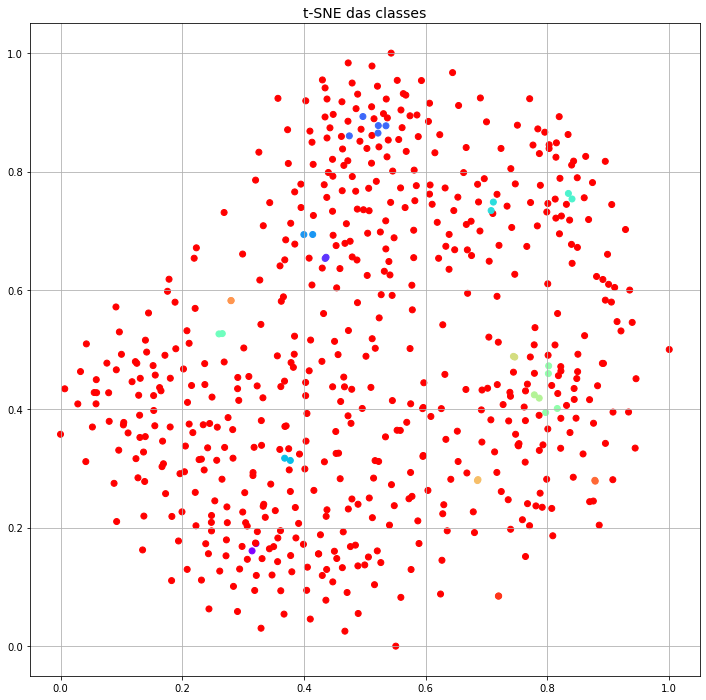


Images 600:
Adjusted rand_score: 0.0022897729132927602
Silhouette: -0.2078075259923935


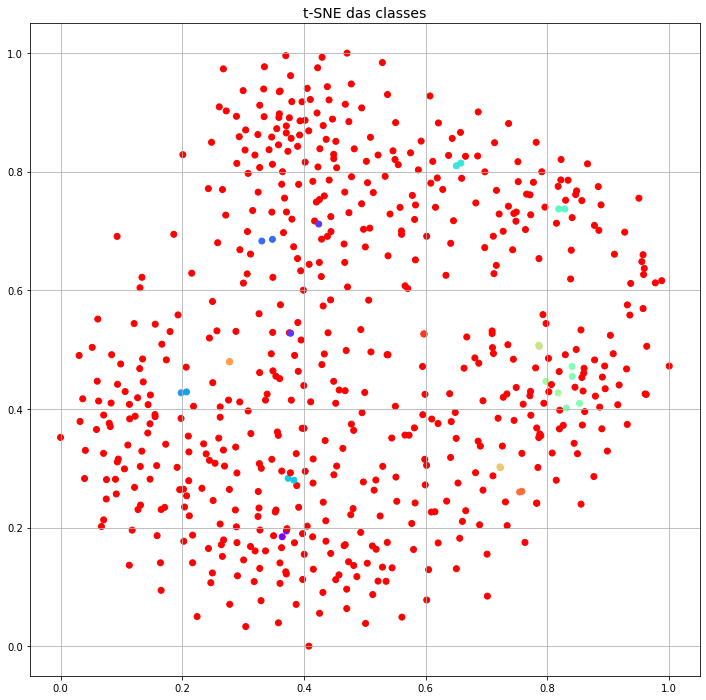


Full data Embeddings:
Adjusted rand_score: 0.004583242799699984
Silhouette: -0.2826157510280609


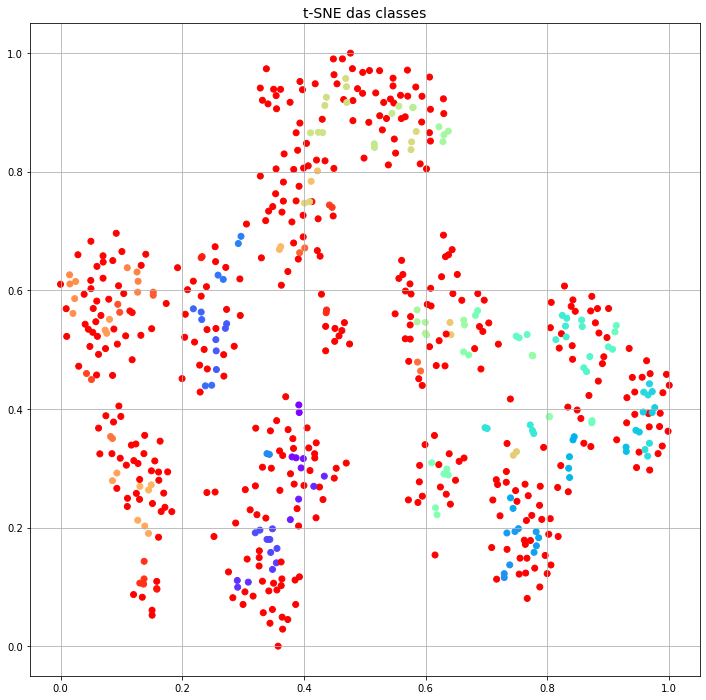


Partial data Embeddings:
Adjusted rand_score: 0.006976327674176935
Silhouette: -0.2786110043525696


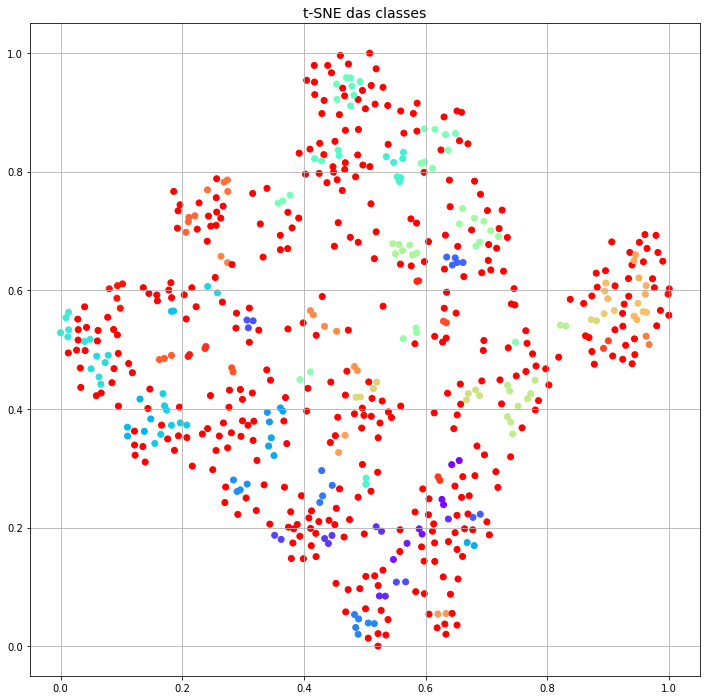

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, OPTICS(min_samples=2, n_jobs=-1))

print("Images 600:")
run_on_batch(images_600, true_labels, OPTICS(min_samples=2, n_jobs=-1))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, OPTICS(min_samples=2, n_jobs=-1))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, OPTICS(min_samples=2, n_jobs=-1))

Na maioria das variantes, ambas as métricas obtiveram resultados ruins, possivelmente por não receber diretamente a quantidade de *clusters* desejada, a natureza do algoritmo não consegue modelar os agrupamentos de uma maneira satisfatória. De maneira geral, a melhor variação para esse algoritmo foi *Partial Data Embeddings* (0.006) e *Images 600* (-0.207), para as métricas de *Adjusted rand score* e *Silhoueta*, respectivamente.

---

# *Agglomerative Clustering*

Nesse projeto, utilizou-se um algoritmo aglomerativo com critério de união *ward*. Para os experimentos, foram
utilizadas as quatro variações do conjunto de dados. Para cada variação, o algoritmo foi executado três vezes,
variando o número de *clusters* utilizado para dividir os dados da forma: 
1.   Número de *clusters* menor que o esperado;
2.   Número de *clusters* igual ao esperado;
3.   Número de *clusters* maior que o esperado.

Execução do algoritmo *Agglomerative Clustering* para as quatro variações e menos *clusters* que o real.

Raw images flatten:
Adjusted rand_score: 0.15398316353441788
Silhouette: 0.04274136573076248


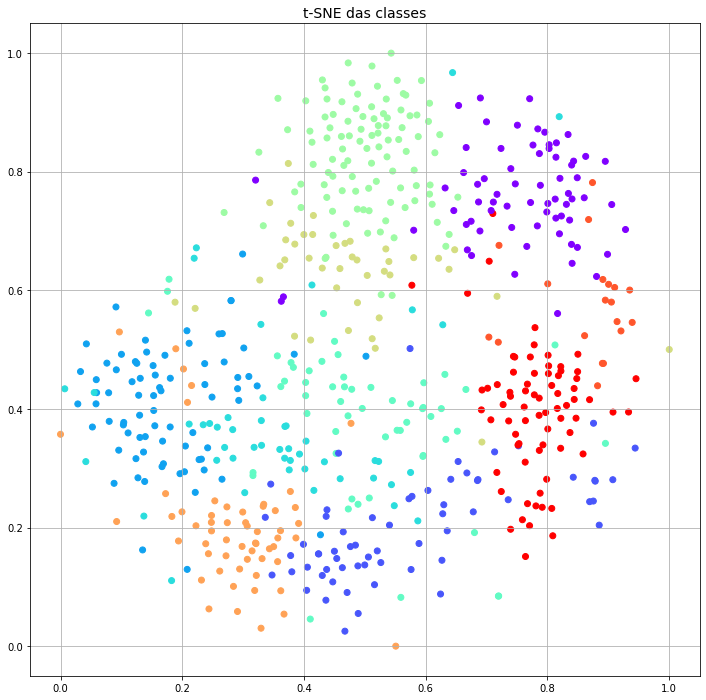


Images 600:
Adjusted rand_score: 0.15398316353441788
Silhouette: 0.04276951774954796


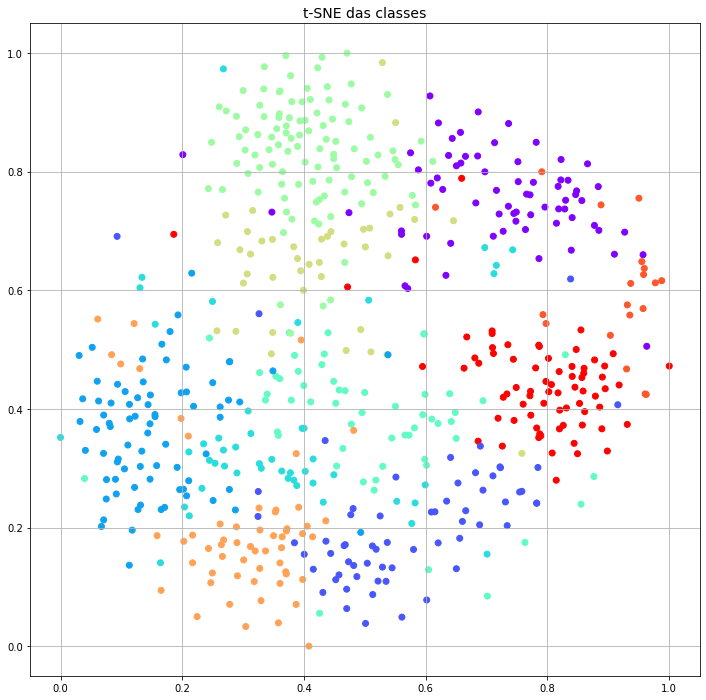


Full data Embeddings:
Adjusted rand_score: 0.5199273323768115
Silhouette: 0.1603071540594101


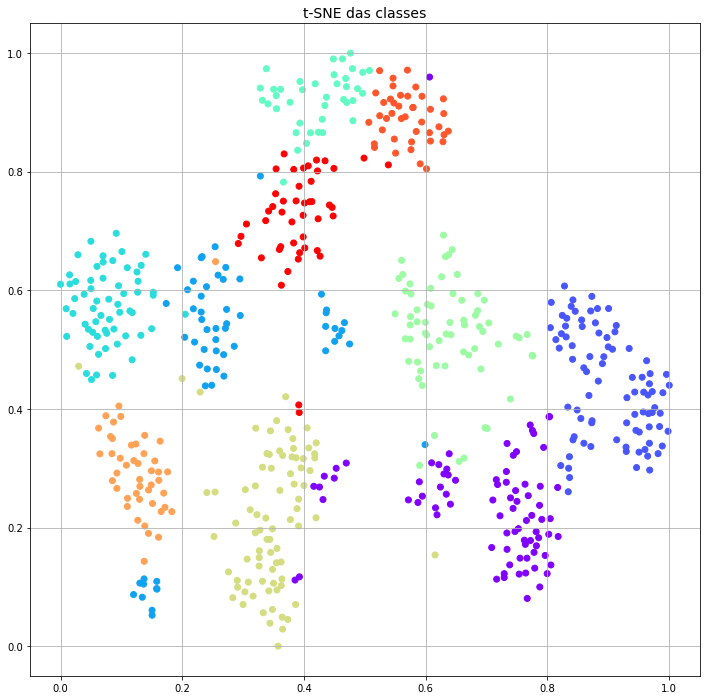


Partial data Embeddings:
Adjusted rand_score: 0.42647289925355414
Silhouette: 0.1505504548549652


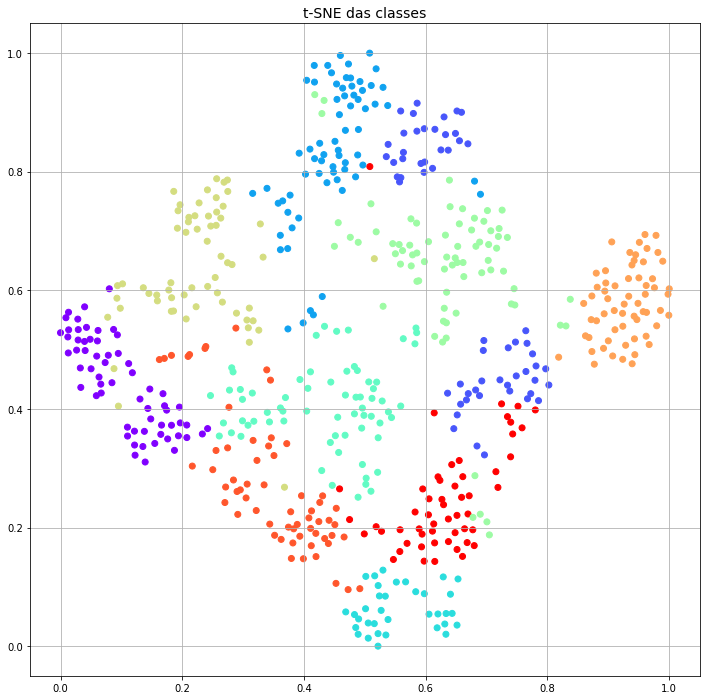

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, AgglomerativeClustering(n_clusters=10))

print("Images 600:")
run_on_batch(images_600, true_labels, AgglomerativeClustering(n_clusters=10))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=10))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=10))

Execução do algoritmo *Agglomerative Clustering* para as quatro variações e com o número de *clusters* igual ao real.

Raw images flatten:
Adjusted rand_score: 0.15534348587046987
Silhouette: 0.022392980754375458


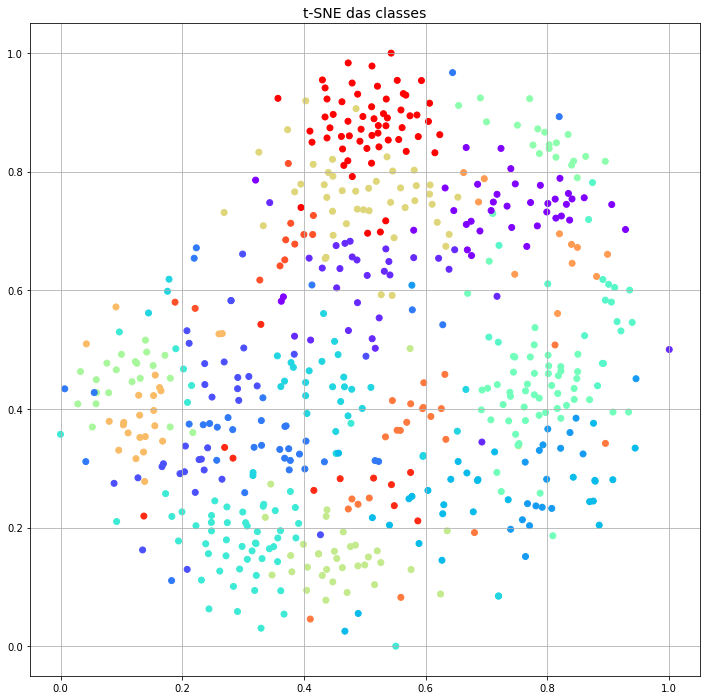


Images 600:
Adjusted rand_score: 0.15534348587046987
Silhouette: 0.022348303347826004


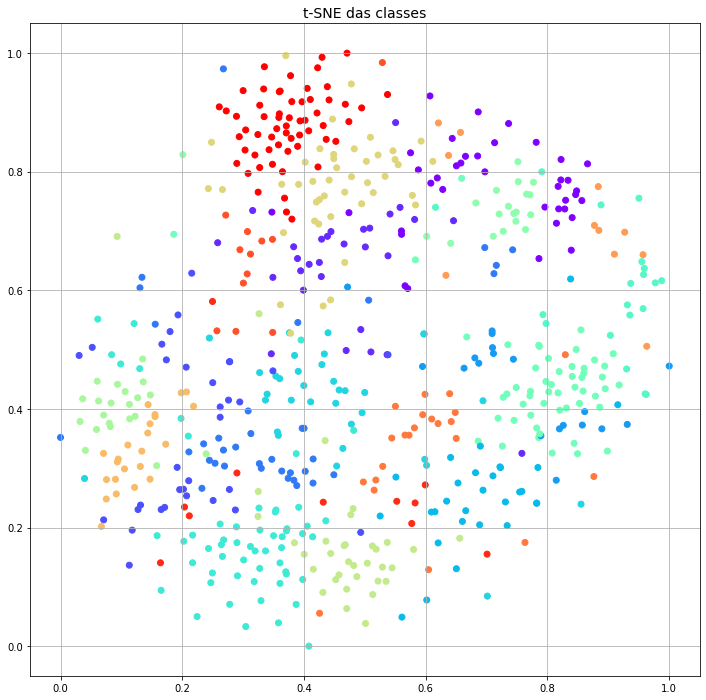


Full data Embeddings:
Adjusted rand_score: 0.6264399627928038
Silhouette: 0.13567766547203064


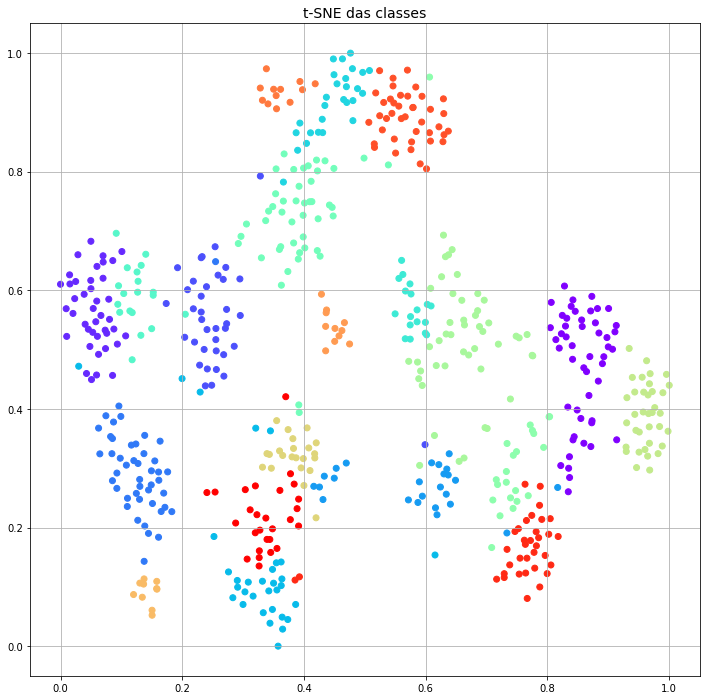


Partial data Embeddings:
Adjusted rand_score: 0.4337080718311752
Silhouette: 0.13114432990550995


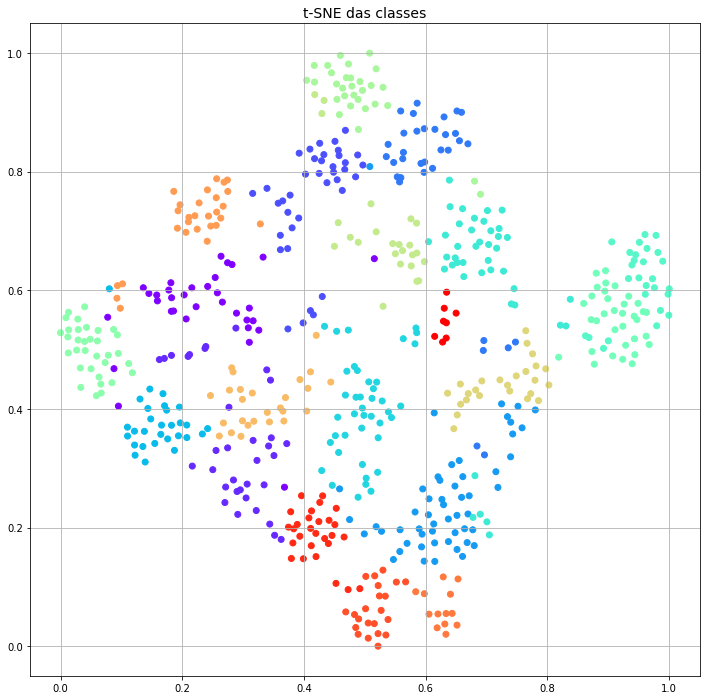

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, AgglomerativeClustering(n_clusters=20))

print("Images 600:")
run_on_batch(images_600, true_labels, AgglomerativeClustering(n_clusters=20))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=20))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=20))

Execução do algoritmo *Agglomerative Clustering* para as quatro variações e mais *clusters* que o real.

Raw images flatten:
Adjusted rand_score: 0.14575537287235432
Silhouette: 0.01881098374724388


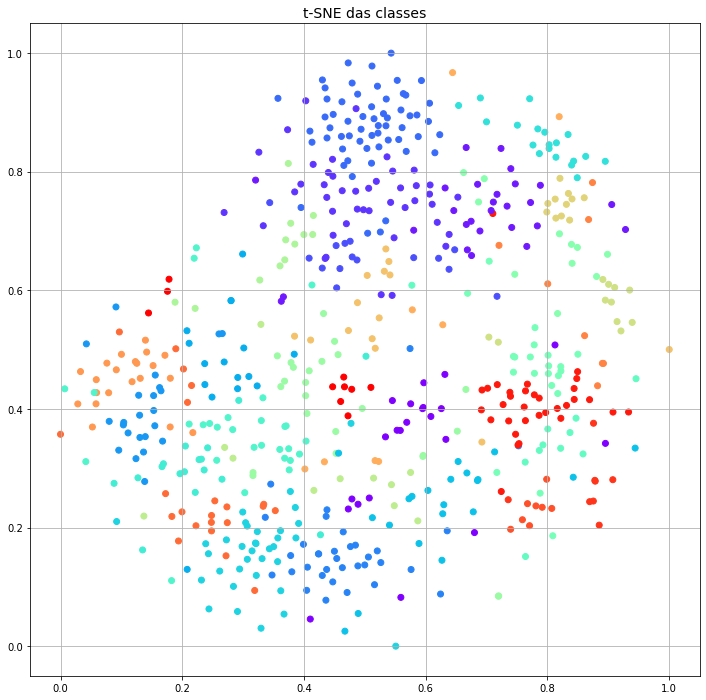


Images 600:
Adjusted rand_score: 0.14575537287235432
Silhouette: 0.018779413774609566


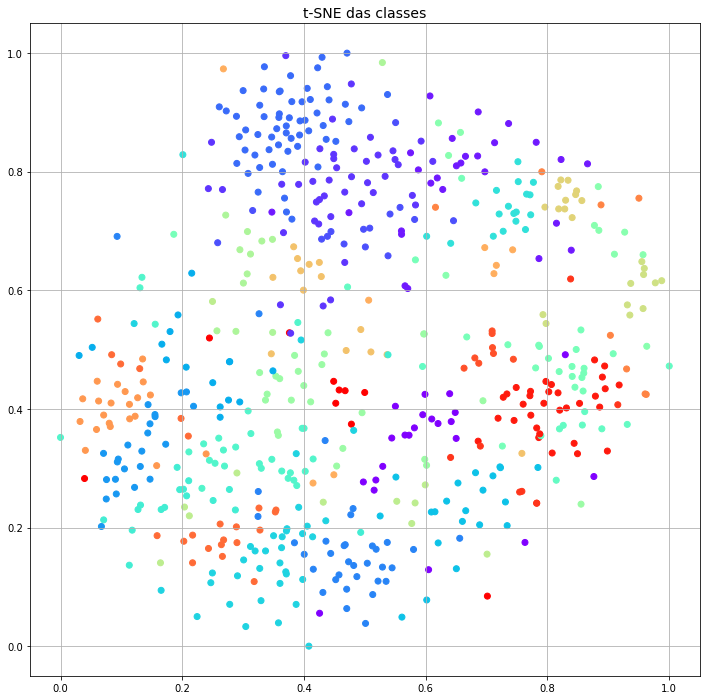


Full data Embeddings:
Adjusted rand_score: 0.5559998046908069
Silhouette: 0.11177092045545578


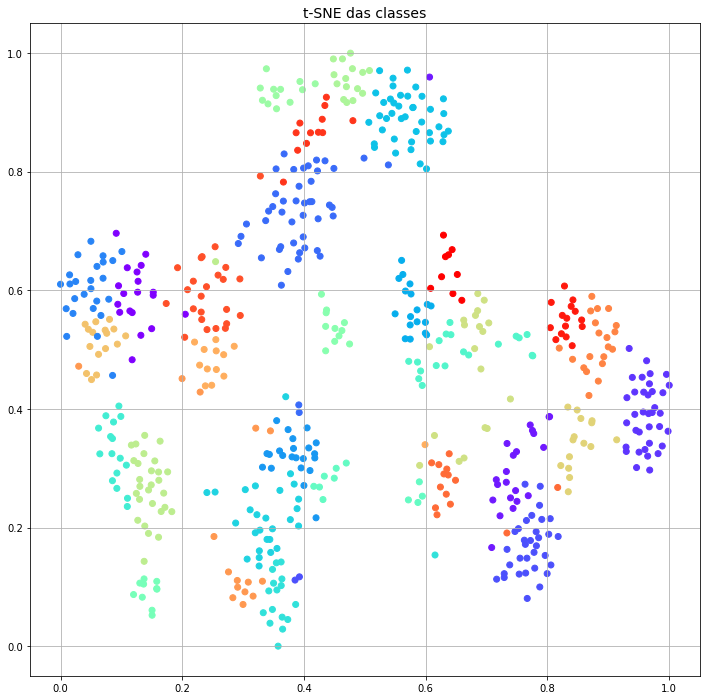


Partial data Embeddings:
Adjusted rand_score: 0.4218953543604572
Silhouette: 0.13220052421092987


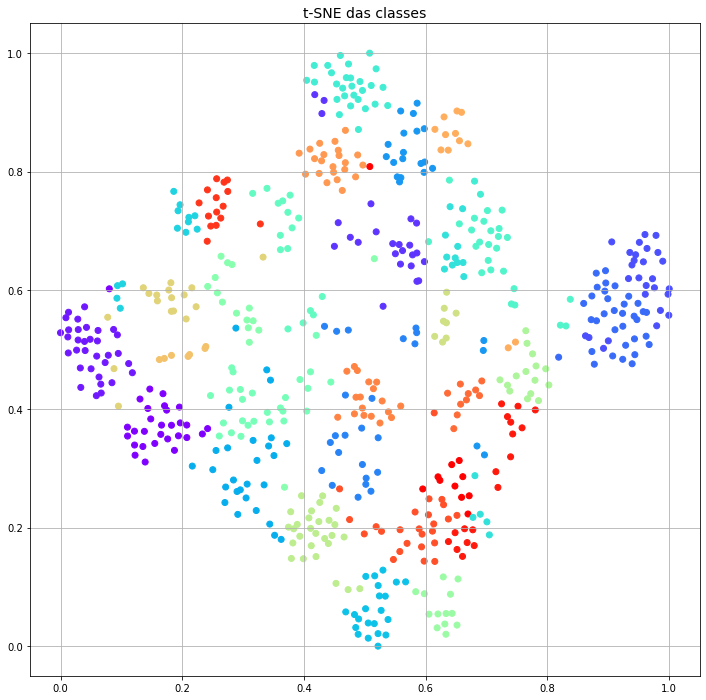

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, AgglomerativeClustering(n_clusters=30))

print("Images 600:")
run_on_batch(images_600, true_labels, AgglomerativeClustering(n_clusters=30))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=30))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, AgglomerativeClustering(n_clusters=30))

Para a maioria das variações do número de *clusters* testadas, os melhores valores para as métricas foram obtidos nos
testes com as *embeddings* do conjunto de dados completo. Os valores obtidos para a silhueta foram baixos, obtendo o valor de
0.16 no teste com 10 *clusters*. Tal valor indica que os *clusters* encontrados não estão tão bem definidos, ou seja, os elementos dos grupos são bastante similares aos elementos de outros grupos. Contudo, isso era esperado, uma vez que os 
exemplos nos dados originais não estão separados em classes bem definidas (confrome pode ser observado na distribuição dos dados). Quanto à métrica *rand index* ajustado, obteve-se um valor de 0.63 quando utilizados 20 *clusters*. Tal valor indica
que os exemplos agrupados em um cluster são razoavelmente semelhantes uns aos outros. Logo, como um valor maior
do *rand index* ajustado é preferível ao valor da silhueta, nesse caso, uma configuração com 20 *clusters* fornece melhores resultados.

---

# *K-Means*

Raw images flatten:
Adjusted rand_score: 0.13168493226377845
Silhouette: 0.04306824505329132


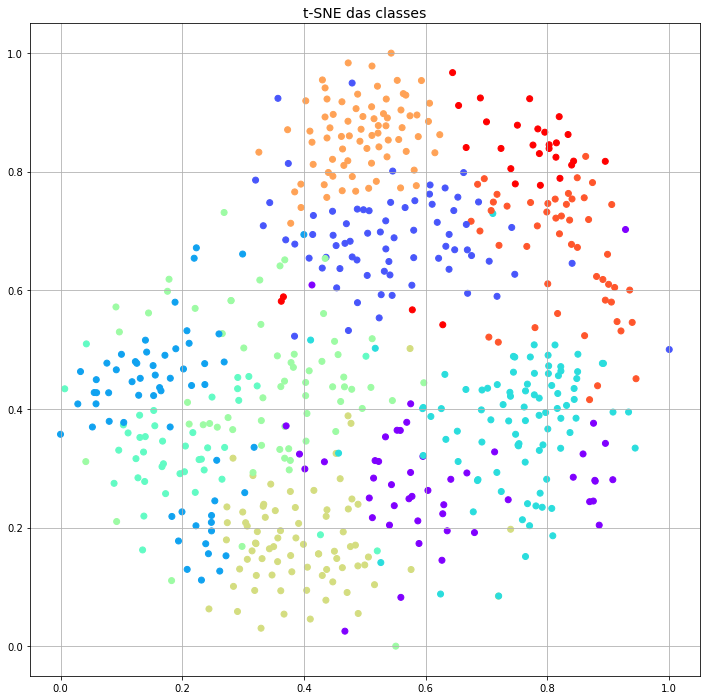


Images 600:
Adjusted rand_score: 0.13168493226377845
Silhouette: 0.04305698722600937


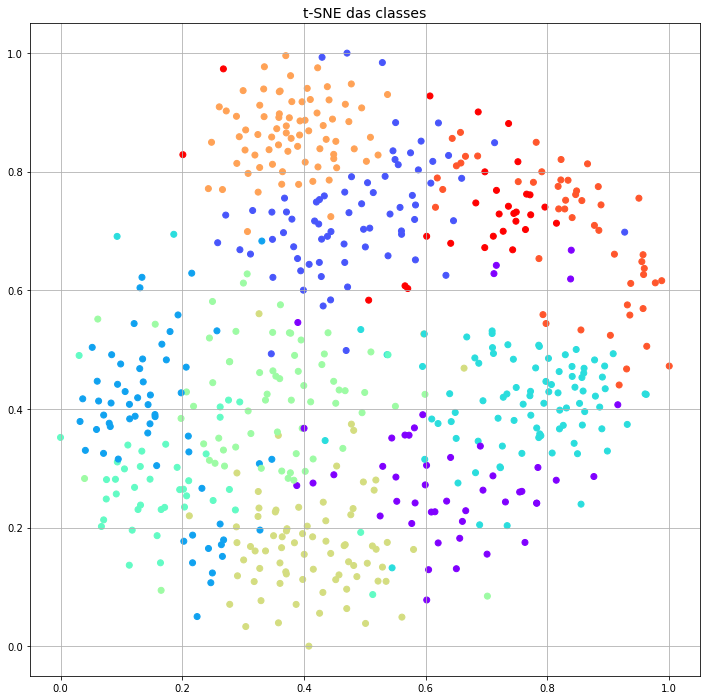


Full data Embeddings:
Adjusted rand_score: 0.5963032338343626
Silhouette: 0.18246562778949738


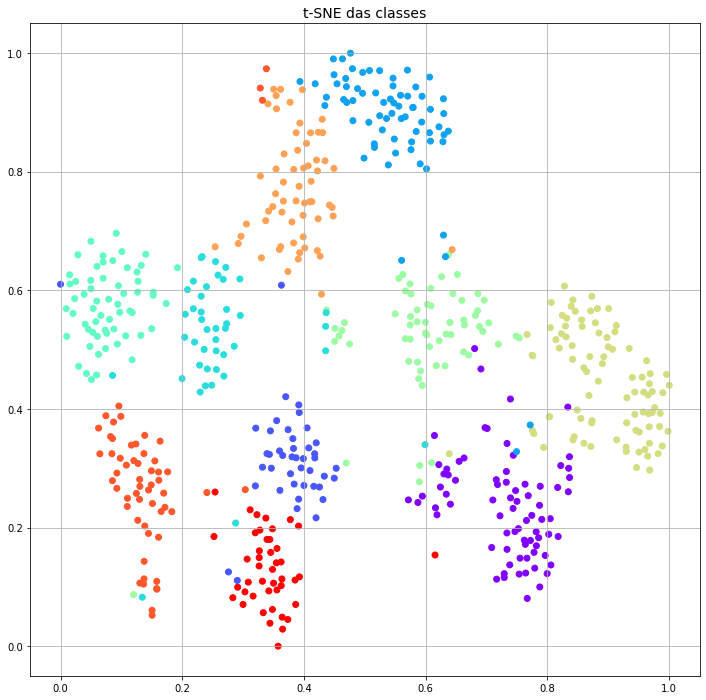


Partial data Embeddings:
Adjusted rand_score: 0.47024996078158027
Silhouette: 0.1814780980348587


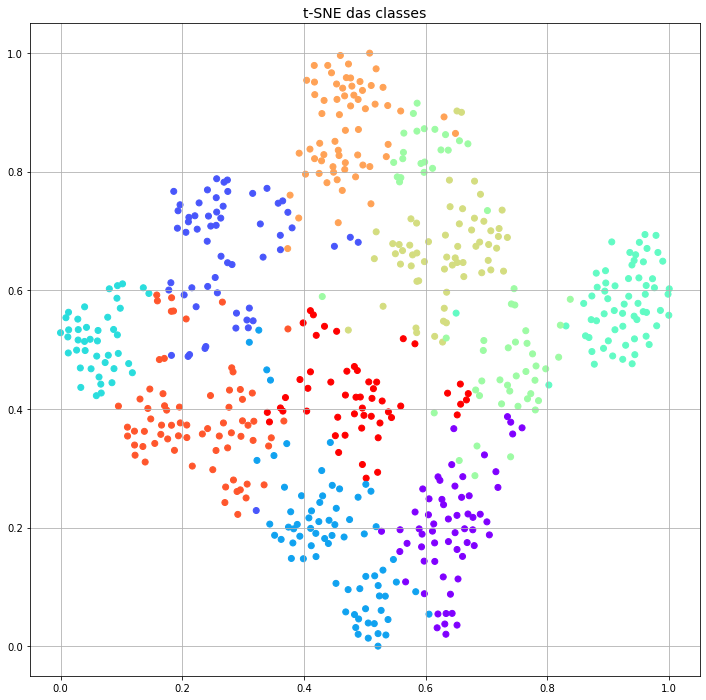

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, KMeans(n_clusters=10, random_state=7))

print("Images 600:")
run_on_batch(images_600, true_labels, KMeans(n_clusters=10, random_state=7))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, KMeans(n_clusters=10, random_state=7))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, KMeans(n_clusters=10, random_state=7))

Raw images flatten:
Adjusted rand_score: 0.14315567797069836
Silhouette: 0.02806868776679039


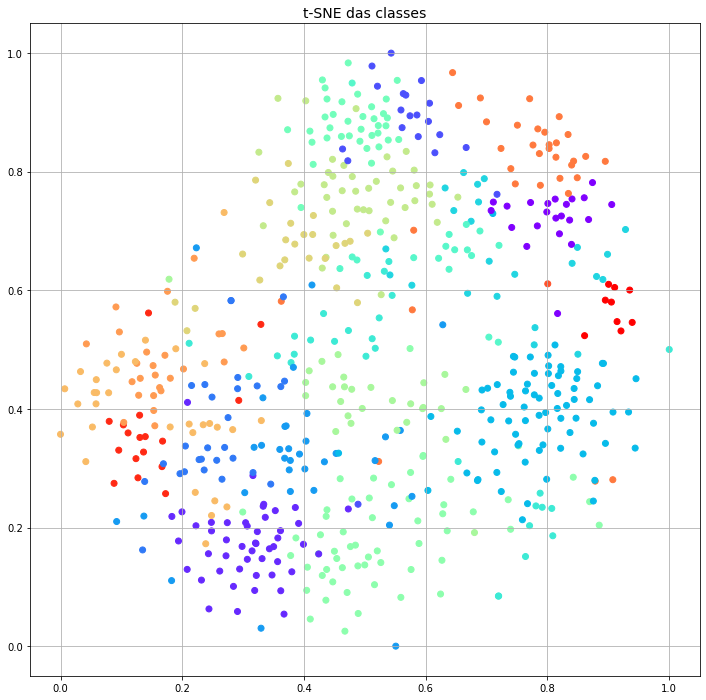


Images 600:
Adjusted rand_score: 0.14207623844365266
Silhouette: 0.02747538313269615


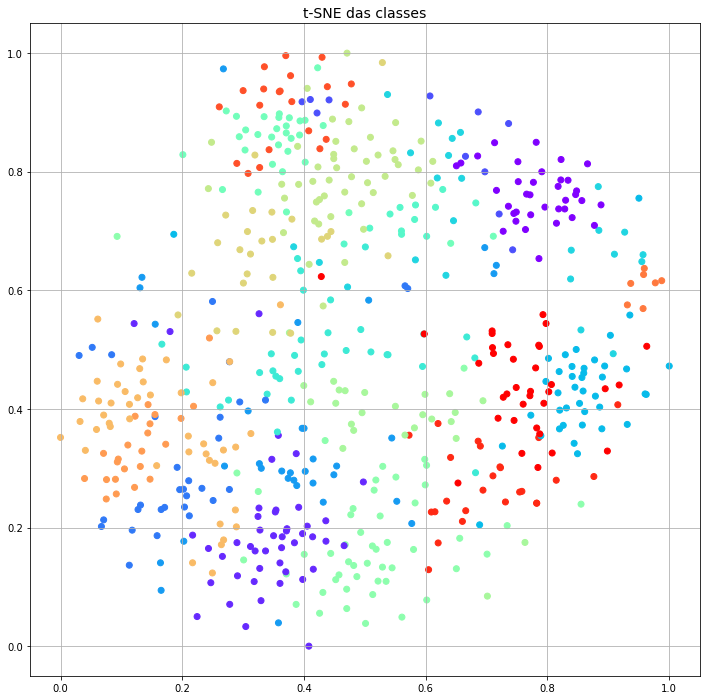


Full data Embeddings:
Adjusted rand_score: 0.6636934561527663
Silhouette: 0.1511283665895462


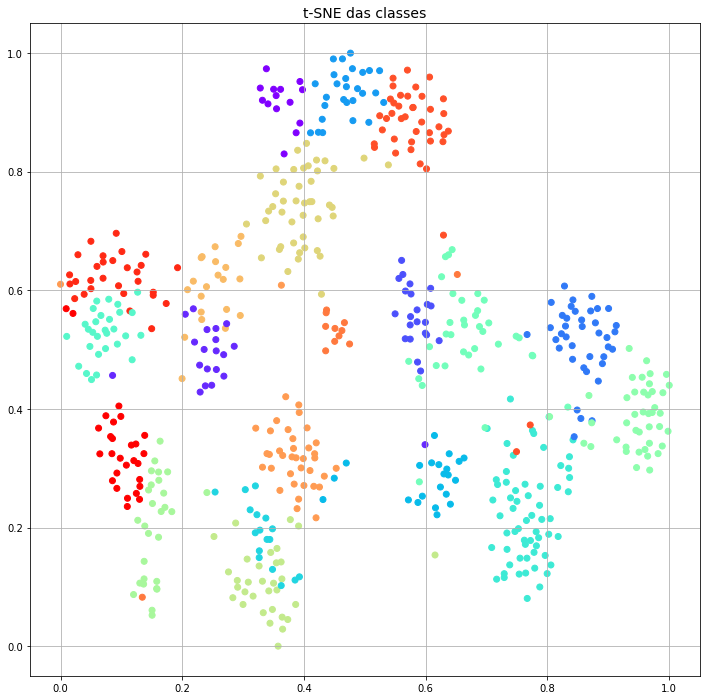


Partial data Embeddings:
Adjusted rand_score: 0.4866718548648416
Silhouette: 0.15369310975074768


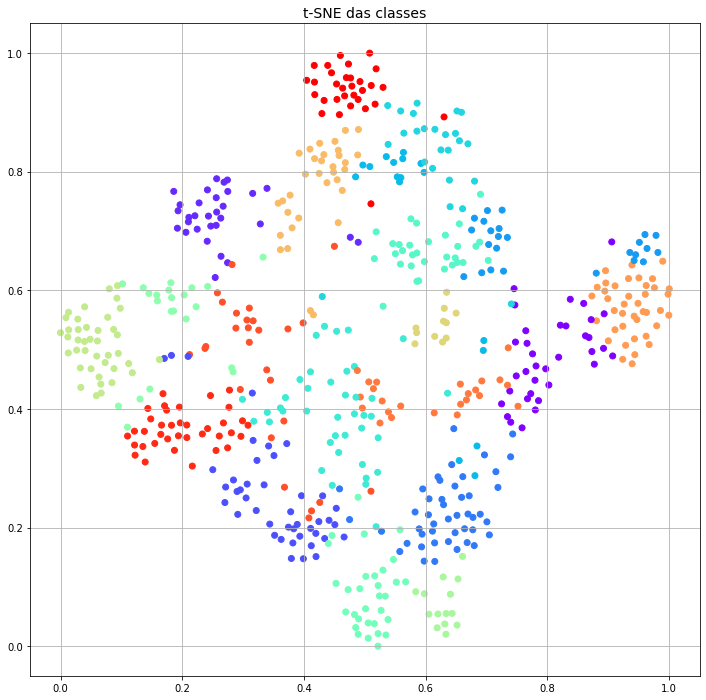

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, KMeans(n_clusters=20, random_state=0))

print("Images 600:")
run_on_batch(images_600, true_labels, KMeans(n_clusters=20, random_state=0))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, KMeans(n_clusters=20, random_state=0))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, KMeans(n_clusters=20, random_state=0))

Raw images flatten:
Adjusted rand_score: 0.10316827047078542
Silhouette: 0.00687818368896842


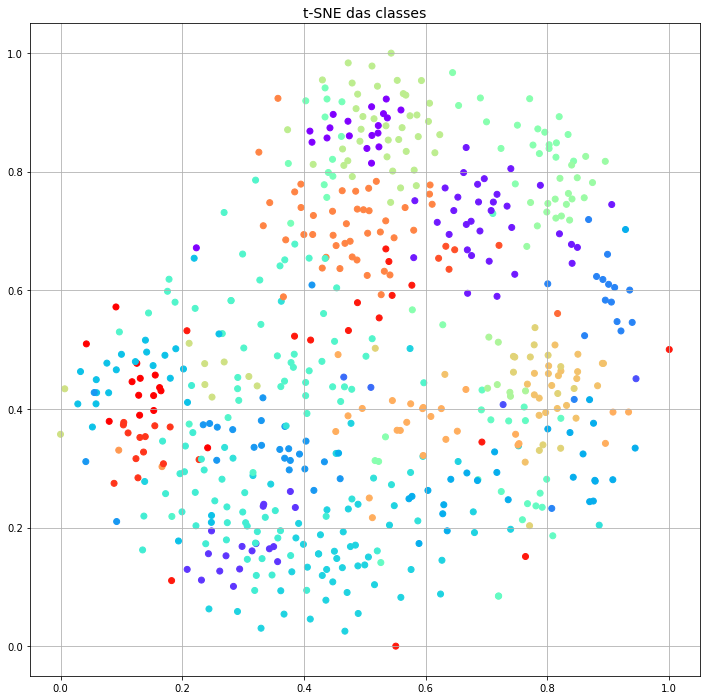


Images 600:
Adjusted rand_score: 0.11035379181307622
Silhouette: 0.015656165778636932


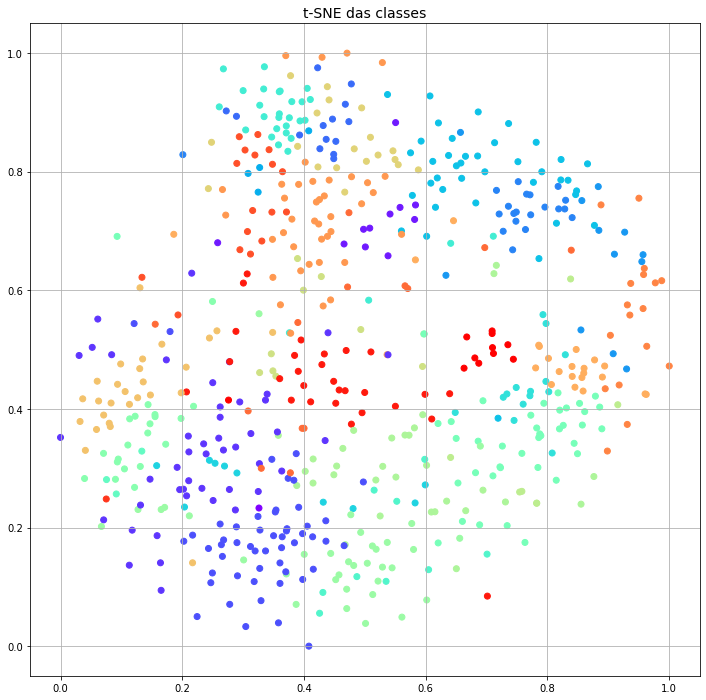


Full data Embeddings:
Adjusted rand_score: 0.6003240166969495
Silhouette: 0.11520956456661224


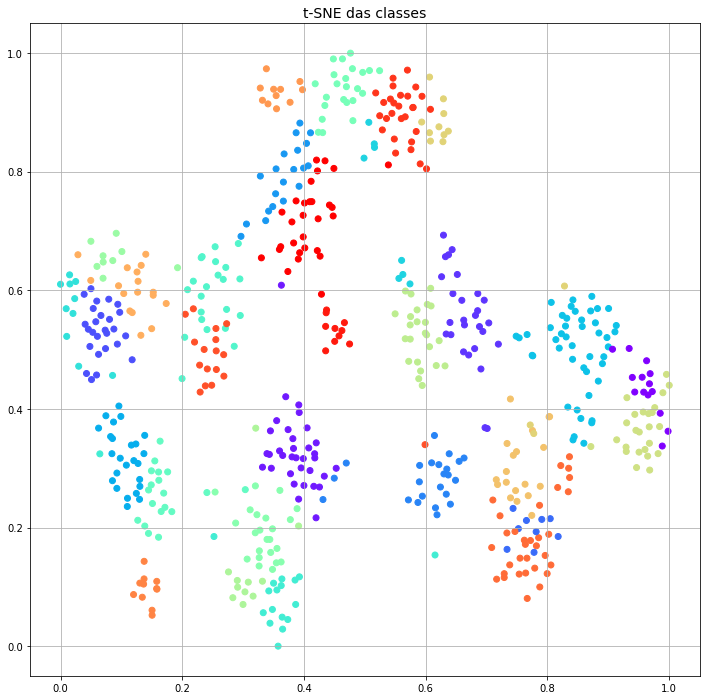


Partial data Embeddings:
Adjusted rand_score: 0.4274830923343919
Silhouette: 0.13317470252513885


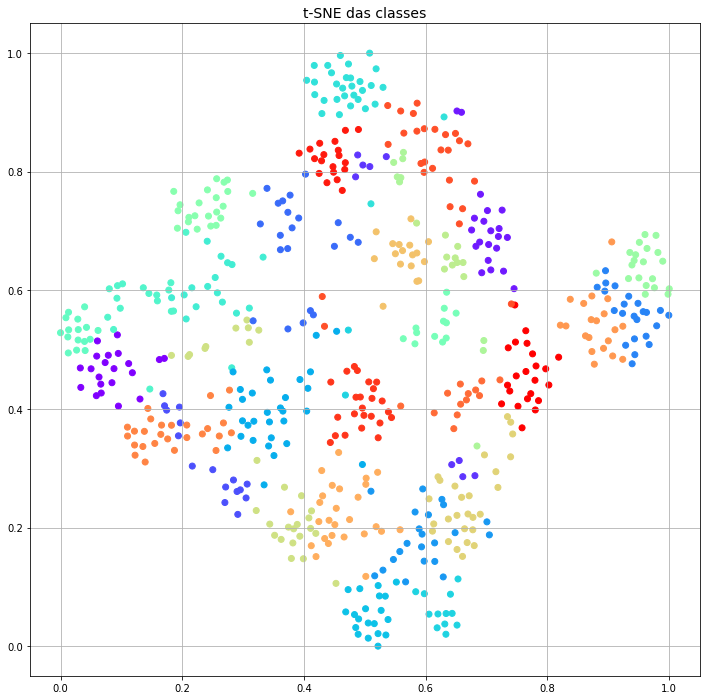

In [ ]:
print("Raw images flatten:")
run_on_batch(raw_images, true_labels, KMeans(n_clusters=30, random_state=11))

print("Images 600:")
run_on_batch(images_600, true_labels, KMeans(n_clusters=30, random_state=11))

print("Full data Embeddings:")
run_on_batch(full_data_embeddings, true_labels, KMeans(n_clusters=30, random_state=11))

print("Partial data Embeddings:")
run_on_batch(partial_data_embeddings, true_labels, KMeans(n_clusters=30, random_state=11))

###*Raw images*
Ao utilizar as imagens naturais, observa-se uma queda de precisão ao aumentar o número de *clusters*. Com 20 *clusters*, houve uma melhora no *rand index*, mas, em geral, ao utilizar 10, os resultados em ambas as métricas ficam melhores.

###Imagem com 600 dimensões
Com esses dados, os resultados ficaram bem próximos aos das imagens naturais para os diferentes valores de *clusters*.

###*Full data embedding* 
Nesse caso, os resultados do *rand score* ajustado aumentaram cerca de 0.5 para cada variação do número de *clusters*, e, apesar da silhueta ter uma melhora, não foi tão considerável como o ganho no *rand score*. E a combinação de métricas com 20 *clusters* foi a mais favorável.

###*Partial data embedding* 
Houve um declínio dos resultados comparado ao anterior, mas, ainda assim, esses são melhores que os *datasets* de 600 dimensões e imagem natural.

###Considerações
Logo, para o algoritmo *K-means* foi possível observar que utilizando o *data embedding* completo com cerca de 20 *clusters* obteve-se o melhor resultado. Ademais, isso é reforçado ao observar o gráfico gerado, uma vez que é identificável os *clusters* mais condensados e distantes aos outros dados.

# Considerações Finais

A tabela a seguir mostra a sintetização de todos os resultados obtidos através de todos os experimentos. 

***Optics*:**

Variação | *Rand index* ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.00246 |  -0.20874
Imagem-600 | 0.00229 | -0.20781
*Data Embedding* Completo | 0.00458 | -0.28262
*Data Embedding* Parcial | 0.00698 | -0.27861

***Agglomerative Clustering* - *Clusters* < real:**

Variação | *Rand index* ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.15398 | 0.04274 
Imagem-600 | 0.15398 | 0.04276
*Data Embedding* Completo | 0.51993 | 0.16031 
*Data Embedding* Parcial | 0.42647 | 0.15055

***Agglomerative Clustering* - *Clusters* = real:**

Variação | *Rand index* ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.15534 | 0.02239 
Imagem-600 | 0.15534 | 0.02235
*Data Embedding* Completo | 0.62644 | 0.13568 
*Data Embedding* Parcial | 0.43371 | 0.13114

***Agglomerative Clustering* - *Clusters* > real:**

Variação | *Rand index* ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.14576 | 0.01881 
Imagem-600 | 0.14576 | 0.01878
*Data Embedding* Completo | 0.55600 | 0.11178 
*Data Embedding* Parcial | 0.42190 | 0.13220

***K-Means* - *Clusters* < real:**

Variação | *Rand index* ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.13168 | 0.04307 
Imagem-600 | 0.13168 | 0.04306 
*Data Embedding* Completo | 0.59630 | 0.18247 
*Data Embedding* Parcial | 0.47025 | 0.18148

***K-Means* - *Clusters* = real:**

Variação | Rand index ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.14316 | 0.02807
Imagem-600 | 0.14208 | 0.02748
*Data Embedding* Completo | 0.66369 | 0.15113
*Data Embedding* Parcial | 0.48667 | 0.15369

***K-Means* - *Clusters* > real:**

Variação | Rand index ajustado | Silhueta
--- | --- | ---
Imagens Naturais | 0.10317 | 0.00688
Imagem-600 | 0.11035 | 0.01566
*Data Embedding* Completo | 0.60032 | 0.11521
*Data Embedding* Parcial | 0.42748 | 0.13317

Para uma melhor comparação, a tabela seguinte mostra o melhor resultado obtido, considerando a métrica *rand index* ajustado, por cada algoritmo.

Algoritmo | Variação | *Rand index* ajustado | Silhueta
--- | --- | --- | ---
*Optics* | *Data Embedding* Parcial | 0.00698 | -0.27861
*Agglomerative Clustering* (<) | *Data Embedding* Completo | 0.51993 | 0.16031
*Agglomerative Clustering* (=) | *Data Embedding* Completo | 0.62644 | 0.13568
*Agglomerative Clustering* (>) | *Data Embedding* Completo | 0.55600 | 0.11178
*K-Means* (<) | *Data Embedding* Completo | 0.59630 | 0.18247 
*K-Means* (=) | *Data Embedding* Completo | 0.66369 | 0.15113
*K-Means* (>) | *Data Embedding* Completo | 0.60032 | 0.11521

Portanto, pode-se observar que o *dataset* de *embeddings* previamente "clusterizadas" com todos os dados foi a melhor variação para a maioria dos algoritmos. Entretanto, vale ressaltar que esse tipo de configuração é difícil de se alcançar em uma aplicação real.

Além disso, o algoritmo K-Means com número de *clusters* igual ao real obteve o melhor resultado segundo a métrica *rand index* ajustado, além de um alto valor de silhueta.